# <center> <font color='red'> Sentiment analyses in textual movie reviews </font>  </center> 

<b>Student :</b> Ahlem JOUIDI

<b> Objectives</b>

The objective of this lab is to implement a classification algorithm of movie reviews according to the
polarity of the opinions expressed (positive / negative). We speak in English of “ sentiment analysis ”.
The algorithm used will be the naive Bayes classifier. The language to use is Python.

### Librairies 

In [1]:
import os.path as op
import numpy as np

import re
from collections import Counter

from sklearn.base import BaseEstimator, ClassifierMixin

from glob import glob

from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [2]:
###############################################################################
# Load data
print("Loading dataset")

filenames_neg = sorted(glob(op.join('data','data', 'imdb1', 'neg', '*.txt')))
filenames_pos = sorted(glob(op.join( 'data','data', 'imdb1', 'pos', '*.txt')))

texts_neg = [open(f).read() for f in filenames_neg]
texts_pos = [open(f).read() for f in filenames_pos]
texts = texts_neg + texts_pos
y = np.ones(len(texts), dtype=np.int)
y[:len(texts_neg)] = 0.

print("%d documents" % len(texts))


Loading dataset
2000 documents


## Implementation of the classifier

### Q1. Complete the count_words function that will count the number of occurrences of each distinct word in a list of string and return vocabulary (the python dictionary) and counts. Do not forget to delete the punctuation. Give the vocabulary size.

In [58]:
###############################################################################
# Start part to fill in

def count_words(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts

    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
        n_samples == number of documents.
        n_features == number of words in vocabulary.
    """
    words = set()
    vocabulary={}
    position=0
    
    ##Built vocabulary
    for text in texts:                 
        text = re.sub(r'[\W_]',' ',text) #remove punctuation
        for word in text.split() :
            
            if word not in words :
                words.add(word)
                vocabulary[word]=position
                position+=1
     
    n_features = len(vocabulary)
    print('The number of features is {}'.format(n_features))
    counts = np.zeros((len(texts), n_features))
    
       
    for (i, text) in enumerate(texts):
        text = re.sub(r'[\W_]',' ',text) #remove punctuation
        for word in text.split():
            counts[i,vocabulary[word]]+=1
   
            
    return vocabulary, counts


In [59]:
# Count words in text
vocabulary, X = count_words(texts)
print(np.array(X))

The number of features is 39399
[[1. 2. 4. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 2. 0. ... 1. 1. 1.]]


### Q2 Explain how positive and negative classes have been assigned to movie reviews (see poldata.README.2.0 file)

According to the poldata.README.2.0 file, movie reviews may not have an explicit note. In the case where there is a note, this one can appear to different place of the file and in different forms.The classification of a file is thus established from the first note of which one is able to identify.

The maximum rating must be specified explicitly in the text, both for numerical rating and star ratings.

- With a five-star system (or compatible number systems): 
      -Three and a half stars and up are considered positive, 
	  -Two stars and below are considered negative.
- With a four star system (or compatible number system):
	   -Three stars and up are considered positive, 
	   -One and a half stars and below are considered negative.  
- With a letter grade system:
	   -B or above is considered positive,
	   -C or below is considered negative.




### Q3. Complete the NB class to implement the Naive Bayes classifier

In [30]:
class NB(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass 

    def fit(self, X, y):
        
        N = len(y) #number of docs
        class_counter = Counter(y)
        C = list(class_counter.keys()) # list of classes 
        nb_C = len(C) # number of classes
        n_features = X.shape[1]
        
      
        self.prior=np.zeros(nb_C) ##Prior probability
        self.cond_prob=np.zeros((nb_C,n_features))   ##conditional probability
       
 
        for(i, c) in enumerate(C):
            self.prior[i] = class_counter[c]/N    ## Calculating Prior probability
            Xc = X[y==c]  ## Get only text of the class c
            Tc = np.sum(Xc, axis=0) ###count of each word in the class c
            self.cond_prob[i] = np.log(Tc +1) - np.log(np.sum(Tc +1))  ##Laplace smoothing
        
        return self
        
    def predict(self, X):
        X = np.array(X)
        self.prediction = np.argmax(np.log(self.prior) + np.dot(X, self.cond_prob.T), axis=1)
        return self.prediction

    def score(self, X, y):
        #print('The predicted rating\n ',self.predict(X))
        return np.mean(self.predict(X) == y)

# Try to fit, predict and score
nb = NB()
nb.fit(X[::2], y[::2])
#print('The original rating\n',y[1::2])
print('The prediction score is ',nb.score(X[1::2], y[1::2]))

The prediction score is  0.81


### Q4. Evaluate the performance of your classifier in cross-validation 5-folds.

In [31]:
nb = NB()
scores = cross_val_score(nb, X[::2], y[::2], cv=5)  ## 5_Folds cross validation

In [32]:
scores

array([0.74 , 0.815, 0.78 , 0.815, 0.79 ])

### Q5. Change the count_words function to ignore the “stop words” in the file data/english.stop. Are the performances improved ?

In [33]:
###############################################################################
# Start part to fill in

def count_words_1(texts, stop_words):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts

    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
        n_samples == number of documents.
        n_features == number of words in vocabulary.
    """
    words = set()
    vocabulary={}
    position=0
    
    ##Built vocabulary
    for (i,text) in enumerate(texts):                 
        text = re.sub(r'[\W_]',' ',text) #remove punctuation
        
        for word in text.split() :
            if word not in stop_words :  ##Counting only words that not exist in stop_words
                
                if word not in words :
                    words.add(word)
                    vocabulary[word]=position
                    position+=1
    
    n_features = len(vocabulary)
    print('The number of features after removing stop words is {}'.format(n_features))
    counts = np.zeros((len(texts), n_features))
    
       
    for (i, text) in enumerate(texts):
        text = re.sub(r'[\W_]',' ',text) #remove punctuation
        for word in text.split():
            if word in words :
                counts[i,vocabulary[word]]+=1
                   
    return vocabulary, counts


In [34]:
##Having the list of stop_words
with open("./data/data/english.stop", 'r') as file:
            stop_words = set(file.read())

In [63]:
# Count words in text
vocabulary, X = count_words_1(texts, stop_words)

# Try to fit, predict and score
nb = NB()
nb.fit(X[::2], y[::2])
#print('The original rating\n',y[1::2])
print('The prediction score is ',nb.score(X[1::2], y[1::2]))

The prediction score is  0.811


In [66]:
nb = NB()
scores_with_stop_words = cross_val_score(nb, X[::2], y[::2], cv=5)  ## 5_Folds cross validation
scores_with_stop_words

array([0.74 , 0.815, 0.78 , 0.815, 0.79 ])

### Testing the performance with several K_Fold cross validation.

In [67]:
vocabulary, X= count_words(texts)
vocabulary_sw, X_stopWords = count_words_1(texts, stop_word=True)
scores = []
scores_stopWords = []
nb = NB()

for cv in range(2,15):
    scores.append(cross_val_score(nb, X, y, cv=cv).mean())
    scores_stopWords.append(cross_val_score(nb, X_stopWords, y, cv=cv).mean())

The number of features is 39399


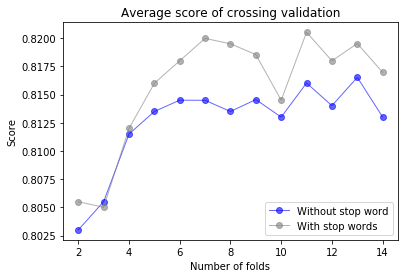

In [68]:
plt.plot(np.arange(2,15), scores, linewidth=1, alpha=0.6,   ##Plot scores of CV with dataset containing stop_words
         marker='o', color="blue", label='Without stop word')

plt.plot(np.arange(2,15), scores_stopWords, linewidth=1, alpha=0.6,  ##Plot scores of CV with dataset without stop_words
         marker='o', color="grey", label='With stop words')
plt.title("Average score of crossing validation")
plt.ylabel('Score')
plt.xlabel('Number of folds')
plt.legend()
plt.show()

We notice that in some folds when we remove stop-words in the texts, we can improve the performance of the estimator. But for other folds the performance are not improved.
We can conclude that this means that the stop words don't always have a significant influence on the results of classification

## Scikit-learn use

In [39]:
##Import labraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from nltk import SnowballStemmer
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

### Q1 : Compare your implementation with scikitlearn.

In [69]:
##Convert the collection of text documents to a matrix of token counts
vectorizer = CountVectorizer()

In [70]:
##Naive Bayes classifier for multinomial models
clf = MultinomialNB()

In [71]:
##Pipeline of transforms with Naive Bayes as final estimator.
vecto_NB = Pipeline([('vectorizer', vectorizer), ('NB', clf)])

In [72]:
## 5_Folds Cross validation for each classifier allowing words, chars and bigrams.

##Counting stop words
CV_NB_word = cross_val_score(vecto_NB.set_params(
    vectorizer__analyzer='word',vectorizer__stop_words=None), texts, y, cv=5)
CV_NB_char = cross_val_score(vecto_NB.set_params(
    vectorizer__analyzer='char',vectorizer__stop_words=None), texts, y, cv=5)
CV_bigram_word = cross_val_score(vecto_NB.set_params(
    vectorizer__analyzer='word', vectorizer__ngram_range=(2, 2), vectorizer__stop_words=None), texts, y, cv=5)


##Eliminating stop words
CV_NB_word_sw = cross_val_score(vecto_NB.set_params(
    vectorizer__analyzer='word',vectorizer__stop_words='english'), texts, y, cv=5)
CV_NB_char_sw = cross_val_score(vecto_NB.set_params(
    vectorizer__analyzer='char',vectorizer__stop_words='english'), texts, y, cv=5)
CV_bigram_word_sw = cross_val_score(vecto_NB.set_params(
    vectorizer__analyzer='word', vectorizer__ngram_range=(2, 2), vectorizer__stop_words='english'), texts, y, cv=5)

[]

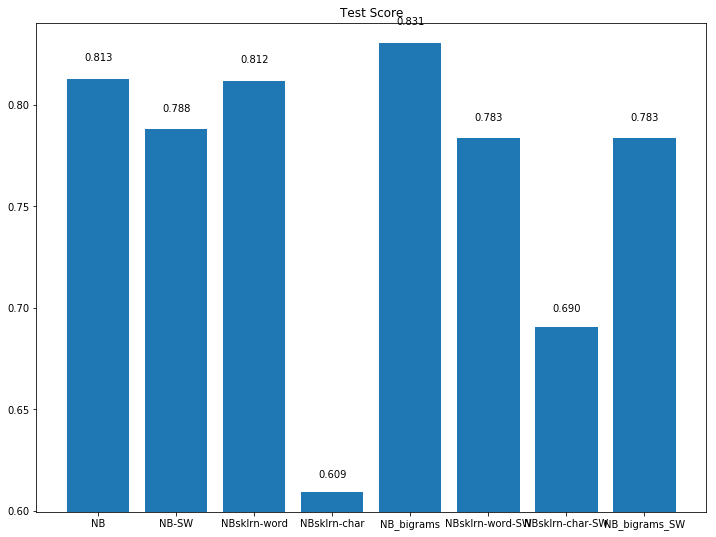

In [73]:
label = ['NB', 'NB-SW','NBsklrn-word'  , 'NBsklrn-char'
         , 'NB_bigrams'
         ,'NBsklrn-word-SW'
         , 'NBsklrn-char-SW','NB_bigrams_SW' ]
data = [scores,scores_with_stop_words,CV_NB_word
           ,CV_NB_char
           ,CV_bigram_word
           ,CV_NB_word_sw
           ,CV_NB_char_sw
           ,CV_bigram_word_sw
          ]

fig,ax = plt.subplots(figsize=(12,9))

x = [np.mean(res) for res in data]
rect = ax.bar(range(len(label)),x, tick_label =label)
plt.ylim(min(x) -0.01, max(x) + 0.01)
plt.title("Test Score")
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%.3f' % height,
                ha='center', va='bottom')

autolabel(rect)

plt.plot()

Our imlementation has good result comparing to sklearn librairies.
According to the results, using substrings and characters we get the lowest results.
Removing stop words not always improve performance.
Using biagrams can imporve results.

In the following work i will experiment classifiers by allowing words.

### Q2 : Test another classification method scikitlearn (ex : LinearSVC, LogisticRegression).

In [74]:
##Using LinearSVC
clf = LinearSVC()
vecto_svc = Pipeline([('vectorizer', vectorizer), ('svc', clf)])

##Using LogisticRegression
clf = LogisticRegression()
vecto_LG = Pipeline([('vectorizer', vectorizer), ('LG', clf)])

In [75]:
##5_Folds Cross validation for each classifier allowing words

##Including stop words
CV_svc = cross_val_score(vecto_svc.set_params(
    vectorizer__analyzer='word',vectorizer__stop_words=None), texts, y, cv=5)

CV_LG=cross_val_score(vecto_LG.set_params(
    vectorizer__analyzer='word',vectorizer__stop_words=None), texts, y, cv=5)

##Eliminating stop words
CV_svc_sw = cross_val_score(vecto_svc.set_params(
    vectorizer__analyzer='word',vectorizer__stop_words='english'), texts, y, cv=5)

CV_LG_sw=cross_val_score(vecto_LG.set_params(
    vectorizer__analyzer='word',vectorizer__stop_words='english'), texts, y, cv=5)

C:\Users\ahlem\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ahlem\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ahlem\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ahlem\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[]

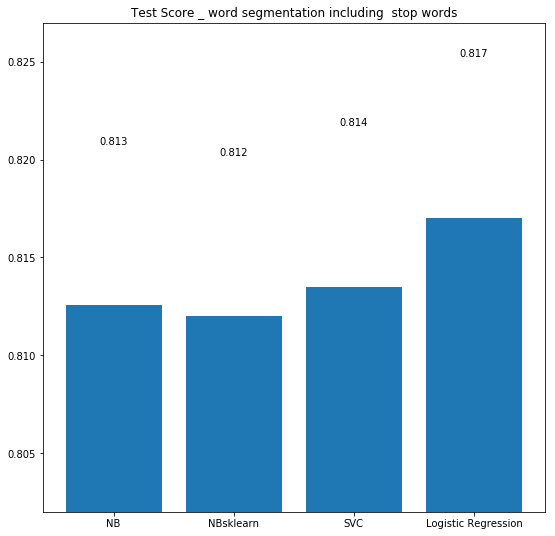

In [76]:
label = ['NB','NBsklearn'  , 'SVC'
         ,'Logistic Regression']
data = [scores,CV_NB_word
           ,CV_svc
           ,CV_LG]

fig,ax = plt.subplots(figsize=(9,9))

x = [np.mean(res) for res in data]
rect = ax.bar(range(len(label)),x, tick_label =label)
plt.ylim(min(x) -0.01, max(x) + 0.01)
plt.title("Test Score _ word segmentation including  stop words")
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%.3f' % height,
                ha='center', va='bottom')

autolabel(rect)

plt.plot()

[]

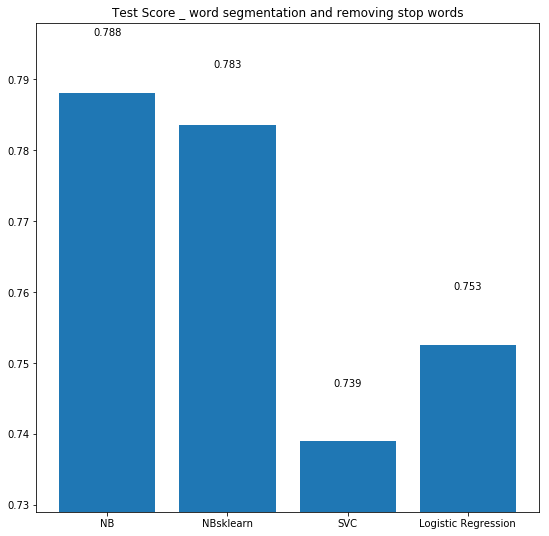

In [77]:
label = ['NB','NBsklearn'  , 'SVC'
         ,'Logistic Regression']
data = [scores_with_stop_words,CV_NB_word_sw
           ,CV_svc_sw
           ,CV_LG_sw]

fig,ax = plt.subplots(figsize=(9,9))

x = [np.mean(res) for res in data]
rect = ax.bar(range(len(label)),x, tick_label =label)
plt.ylim(min(x) -0.01, max(x) + 0.01)
plt.title("Test Score _ word segmentation and removing stop words")
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%.3f' % height,
                ha='center', va='bottom')

autolabel(rect)

plt.plot()

As we see in thoss histogramme, Logistic Regression has the best performance when we segment our text in words and both when we remove and include stop words.

Removing stop words inhance the performance for both LinearSVC and Logistic Regression.

### Question 3 : Use NLTK library in order to process a stemming. You will use the class SnowballStemmer.

In [5]:
##Implementation of the class StemmedCountVectorizer
stemmer = SnowballStemmer("english")
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [7]:
##Naive Bayes with stemmer
NB= MultinomialNB()
vecto_NB_stm = Pipeline([('vectorizer', StemmedCountVectorizer()), ('NB', NB)])
nb_stem_score = np.mean(cross_val_score(vecto_NB_stm, texts, y, cv=5))

In [8]:
## LogisticRegression with stemmer
vecto_LG_stm = Pipeline([('vectorizer', StemmedCountVectorizer()),
                      ('LR', LogisticRegression())])
lG_stem_score = np.mean(cross_val_score(vecto_LG_stm, texts, y, cv=5))

C:\Users\ahlem\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
##Linear SVC with stemmer
svc = LinearSVC()
vecto_NB_stm = Pipeline([('vectorizer', StemmedCountVectorizer()), ('svc', svc)])
nb_stem_score = np.mean(cross_val_score(vecto_NB_stm, texts, y, cv=5))

C:\Users\ahlem\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[]

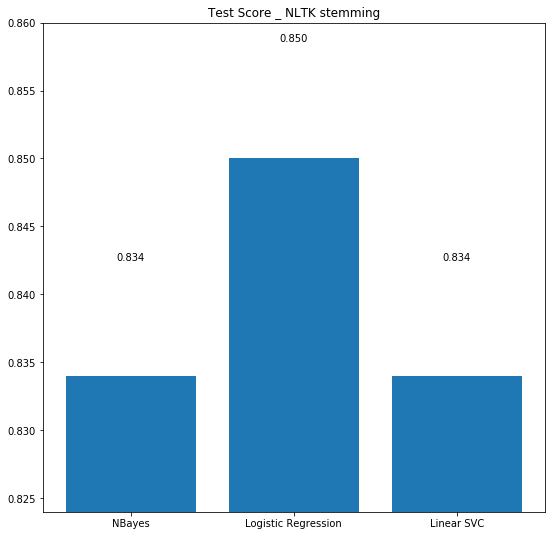

In [12]:
label = ['NBayes','Logistic Regression'  , 'Linear SVC'
         ]
data = [nb_stem_score,lG_stem_score
           ,nb_stem_score
           ]

fig,ax = plt.subplots(figsize=(9,9))

x = [np.mean(res) for res in data]
rect = ax.bar(range(len(label)),x, tick_label =label)
plt.ylim(min(x) -0.01, max(x) + 0.01)
plt.title("Test Score _ NLTK stemming")
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%.3f' % height,
                ha='center', va='bottom')

autolabel(rect)

plt.plot()

### Q4 : Filter words by grammatical category (POS : Part Of Speech) and keep only nouns,verbs, adverbs and adjectives for classification.

In [55]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ahlem\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [60]:
##Tokenize sentences using word_tokenize
##Appling POS TAG on each word
##Filering the POS TAG to keep only words that are noun, verb, adjective or adverb.
filtered_tagged_words = [list(filter(lambda x: (x[1] == 'NN')   
                         or (x[1] == 'VB') 
                         or (x[1] == 'DT') 
                         or (x[1] == 'JJ')
                         or (x[1]=='RB'), pos_tag(word_tokenize(txt)))) for txt in texts]
   

In [73]:
filtered_tagged_words[1]

[('the', 'DT'),
 ('happy', 'JJ'),
 ('bastard', 'NN'),
 ('quick', 'JJ'),
 ('movie', 'NN'),
 ('review', 'NN'),
 ('damn', 'NN'),
 ('bug', 'NN'),
 ('a', 'DT'),
 ('head', 'JJ'),
 ('start', 'NN'),
 ('this', 'DT'),
 ('movie', 'NN'),
 ('jamie', 'NN'),
 ('lee', 'NN'),
 ('curtis', 'NN'),
 ('another', 'DT'),
 ('baldwin', 'NN'),
 ('brother', 'NN'),
 ('this', 'DT'),
 ('time', 'NN'),
 ('a', 'DT'),
 ('story', 'NN'),
 ('a', 'DT'),
 ('crew', 'NN'),
 ('a', 'DT'),
 ('tugboat', 'NN'),
 ('a', 'DT'),
 ('deserted', 'JJ'),
 ('russian', 'JJ'),
 ('tech', 'NN'),
 ('ship', 'NN'),
 ('a', 'DT'),
 ('strangeness', 'NN'),
 ('the', 'DT'),
 ('power', 'NN'),
 ('back', 'RB'),
 ('little', 'JJ'),
 ('know', 'VB'),
 ('the', 'DT'),
 ('power', 'NN'),
 ('the', 'DT'),
 ('gore', 'NN'),
 ('a', 'DT'),
 ('few', 'JJ'),
 ('action', 'NN'),
 ('here', 'RB'),
 ('there', 'RB'),
 ('virus', 'NN'),
 ('still', 'RB'),
 ('very', 'RB'),
 ('empty', 'JJ'),
 ('a', 'DT'),
 ('movie', 'NN'),
 ('all', 'DT'),
 ('flash', 'NN'),
 ('no', 'DT'),
 ('substance'

In [63]:
##Construct the final vocabulary of word after stemming and POS Tagging 
def extract_vocab(filtered):
    postagged = []
    for i, tuples in enumerate(filtered, 0):
        postagged.append('')
        for t in tuples:
            postagged[i] += t[0] + ' '
    return postagged


In [64]:
filtered_voc=extract_vocab(filtered_tagged_words)

<b>Appling classifiers</b>

In [66]:
## MultinomialNB
nb_pipline = Pipeline([('vectorizer', CountVectorizer()), ('NB', MultinomialNB())])
nb_pos_tag_score = np.mean(cross_val_score(nb_pipline, filtered_voc, y))

C:\Users\ahlem\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [67]:
## SVC
svc_pipline = Pipeline([('vectorizer', CountVectorizer()),
                      ('svc', LinearSVC())])
svc_pos_tag_score = np.mean(cross_val_score(svc_pipline, filtered_voc, y))

C:\Users\ahlem\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [68]:
## LogisticRegression
lr_pipline = Pipeline([('vectorizer', CountVectorizer()),
                      ('lr', LogisticRegression())])
lr_pos_tag_score = np.mean(cross_val_score(lr_pipline, filtered_voc, y))

C:\Users\ahlem\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\ahlem\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The scores obtained are lower than those obtained without stemming and POS tagging. the Stem and pos-tag don t have a significant influence on the classification of document with our samples.


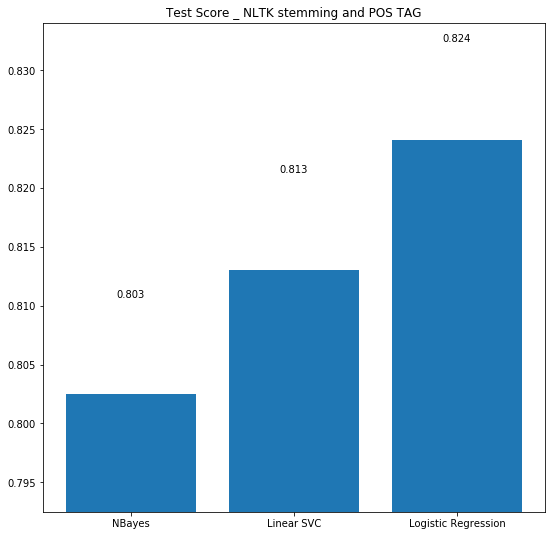

In [74]:
label = ['NBayes'  , 'Linear SVC','Logistic Regression'
         ]
data = [nb_pos_tag_score,svc_pos_tag_score
           ,lr_pos_tag_score
           ]

fig,ax = plt.subplots(figsize=(9,9))

x = [np.mean(res) for res in data]
rect = ax.bar(range(len(label)),x, tick_label =label)
plt.ylim(min(x) -0.01, max(x) + 0.01)
plt.title("Test Score _ NLTK stemming and POS TAG")
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%.3f' % height,
                ha='center', va='bottom')

autolabel(rect)

plt.plot()
print('The scores obtained are lower than those obtained without stemming and POS tagging. the Stem and pos-tag don t have a significant influence on the classification of document with our samples.')

The scores obtained are lower than those obtained without stemming and POS tagging. 
the Stem and pos-tag don't have a significant influence on the classification of document with our samples.

##########################################################################################